In [6]:
# libraries

import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import intake
import dask
import regionmask
import warnings
from pathlib import Path
from tqdm import tqdm
from xmip.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# data

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(url)

In [8]:
# load some monthly data from the GFDL-CM4 4-K warming experiment

query = dict(experiment_id='amip-p4K',
             variable_id=['ua', 'va'],
             source_id=['GFDL-CM4'],
             table_id='Amon'
            )

cat = col.search(**query)
print(cat.df['source_id'].unique())

# load data into dictionary
# keys are constructed as 'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

z_kwargs = {'consolidated': True, 'decode_times':True}

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs, preprocess=combined_preprocessing)

# store these on HPCC scratch directory?

['GFDL-CM4']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [30]:
# get a couple datasets out of the dictionary

ds = dset_dict['CFMIP.NOAA-GFDL.GFDL-CM4.amip-p4K.Amon.gr1']

In [40]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_data = {}
for i, mon in enumerate(months, start=1):
    data = ds.sel(time=ds.time.dt.month == i)
    monthly_data[mon] = data.mean(dim = 'time')

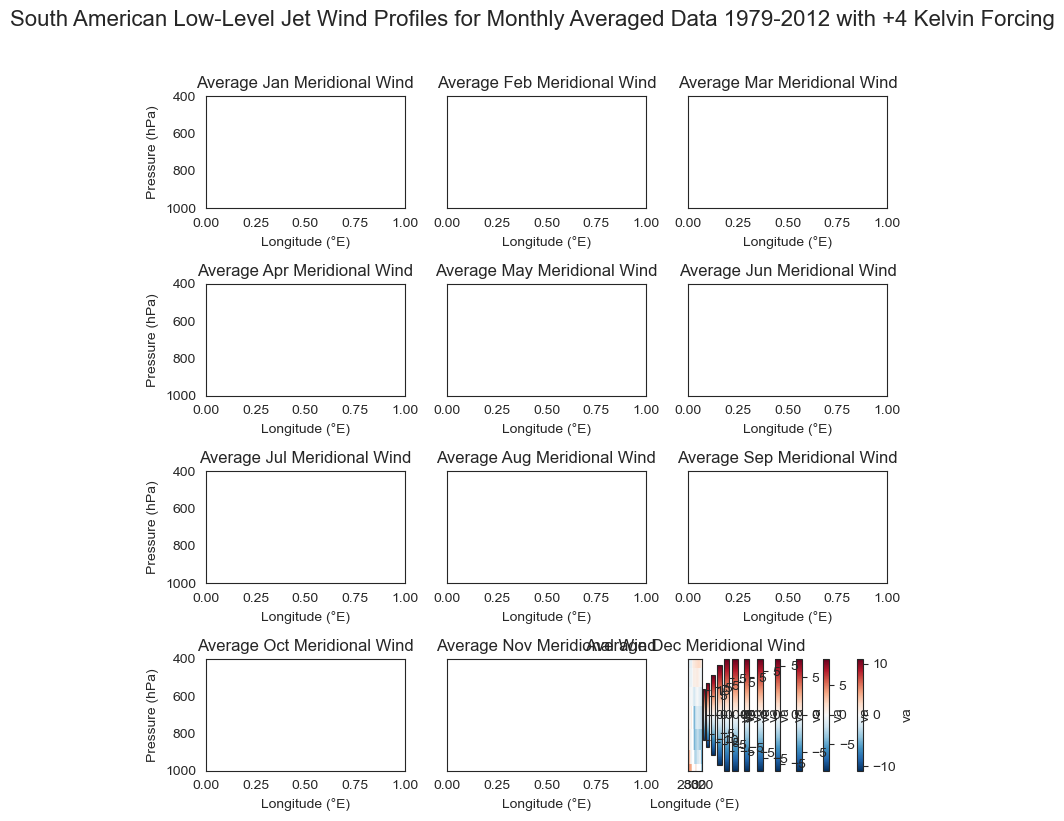

In [ ]:
# plot setup
sns.set_style('white')
titles = [f'{mon} Meridional Winds' for mon in months]

# create 2x3 subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8), sharey=True)

# flatten axes for easy looping
axes = axes.flatten()

# loop through and plot
for i, (ax, mon) in enumerate(zip(axes, months)):
    monthly_data[mon].va.sel(x=slice(280, 320), y=-20.5).assign_coords(plev=ds['plev'] / 100).plot(ax=ax)
    ax.set_ylim(1000, 400)
    ax.set_title(titles[i])
    ax.set_xlabel('Longitude (°E)')
    if i % 4 == 0:
        ax.set_ylabel('Pressure (hPa)')
    else:
        ax.set_ylabel('')

# adjust layout
plt.suptitle('South American Low-Level Jet Wind Profiles for Monthly Averaged Data 1979-2012 with +4 Kelvin Forcing', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()